<a href="https://colab.research.google.com/github/santule/ERA/blob/main/session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data  = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [ ]:
batch_size = 128

kwargs1 = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader  = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs1)

CODE BLOCK: 6

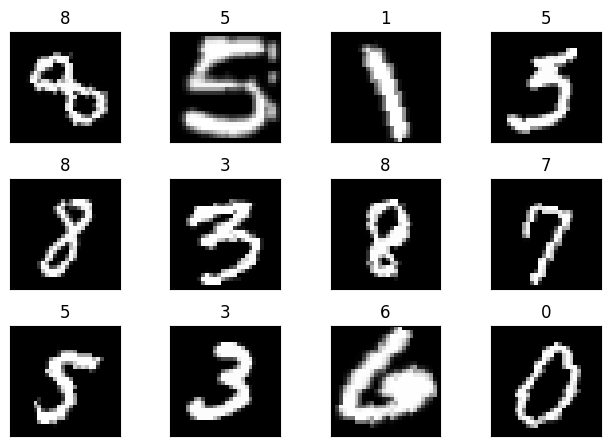

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,bias=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,bias=False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,bias=False)
        self.fc1 = nn.Linear(256*4*4, 50,bias=False)
        self.fc2 = nn.Linear(50, 10,bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        x = x.view(-1, 256*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [ ]:
device = 'cuda' if cuda else 'cpu'
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0213 Batch_id=468 Accuracy=87.58: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]


Test set: Average loss: 0.0526, Accuracy: 9825/10000 (98.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0893 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]


Test set: Average loss: 0.0417, Accuracy: 9873/10000 (98.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0630 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


Test set: Average loss: 0.0310, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0197 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]


Test set: Average loss: 0.0295, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0144 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]


Test set: Average loss: 0.0226, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0491 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]


Test set: Average loss: 0.0227, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0140 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


Test set: Average loss: 0.0277, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0485 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]


Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0264 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0020 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0050 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]


Test set: Average loss: 0.0218, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0163 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0296 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]


Test set: Average loss: 0.0187, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0065 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]


Test set: Average loss: 0.0203, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0018 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0011 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]


Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0283 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]


Test set: Average loss: 0.0158, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0031 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]


Test set: Average loss: 0.0161, Accuracy: 9948/10000 (99.48%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0299 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]


Test set: Average loss: 0.0160, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0005 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]


Test set: Average loss: 0.0159, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

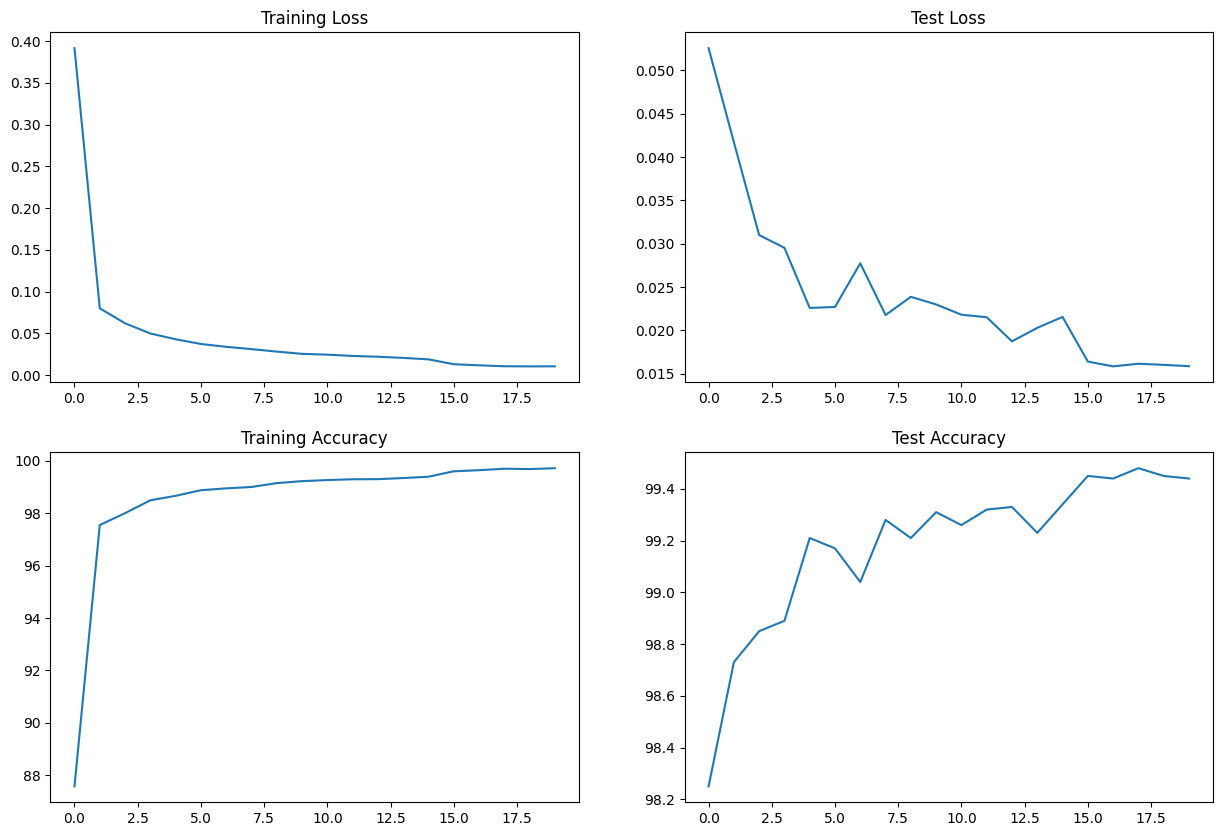

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------
